# Predictive maintanance

Made by: Joey Einerhand, Cédric Cortenraede, Lennox Narinx, Giuseppe Collura

## Data loading
_Loading all the text files with data to use for the prediction model._

In [171]:
import pandas as pd

# Cooler condition (%)
df_ce = pd.read_csv("data/CE.txt", sep="\t", header=None, names=["CE"])

# Valve condition (%)
df_se = pd.read_csv("data/SE.txt", sep="\t", header=None, names=["SE"])

# Internal pump leakage (l/min)
df_fs1 = pd.read_csv("data/FS1.txt", sep="\t", header=None, names=["FS1"])
df_fs2 = pd.read_csv("data/FS2.txt", sep="\t", header=None, names=["FS2"])

# Hydraulic accumulator (bar)
df_ps1 = pd.read_csv("data/PS1.txt", sep="\t", header=None, names=["PS1"])
df_ps2 = pd.read_csv("data/PS2.txt", sep="\t", header=None, names=["PS2"])
df_ps3 = pd.read_csv("data/PS3.txt", sep="\t", header=None, names=["PS3"])
df_ps4 = pd.read_csv("data/PS4.txt", sep="\t", header=None, names=["PS4"])
df_ps5 = pd.read_csv("data/PS5.txt", sep="\t", header=None, names=["PS5"])
df_ps6 = pd.read_csv("data/PS6.txt", sep="\t", header=None, names=["PS6"])

# Severity grade for each type
df_severity = pd.read_csv("data/profile.txt", sep="\t", header=None, names=["Severity"])

## Data Cleaning
_After loading all the data this data will be transformed to be used for the prediction model._


1. First the sensors with multiple data points will be added to a single DataFrame.  
2. Then all DataFrames will be added to a single DataFrame for easier access to the data.
3. The order of columns will be changed next for a more logical order.

In [172]:
# Make seperate dataframes from loaded data
# Dataframe for Internal pump leakage
df_fs = pd.DataFrame()

df_fs["FS1"] = df_fs1["FS1"].to_numpy()
df_fs["FS2"] = df_fs2["FS2"].to_numpy()

# Dataframe for hydraulic accumulator
df_ps = pd.DataFrame()
df_ps["PS1"] = df_ps1["PS1"].to_numpy()
df_ps["PS2"] = df_ps2["PS2"].to_numpy()
df_ps["PS3"] = df_ps3["PS3"].to_numpy()
df_ps["PS4"] = df_ps4["PS4"].to_numpy()
df_ps["PS5"] = df_ps5["PS5"].to_numpy()
df_ps["PS6"] = df_ps6["PS6"].to_numpy()

In [173]:
# Add all data into a single DataFrame for easy access.
df = pd.concat([df_fs, df_ps], axis=1, join="inner")
df["CE"] = df_ce["CE"].to_numpy()
df["SE"] = df_se["SE"].to_numpy()
df["Severity"] = df_severity["Severity"].to_numpy()

df = df.reindex(columns=["CE", "SE", "FS1", "FS2", "PS1", "PS2", "PS3", "PS4", "PS5", "PS6", "Severity"])

df

,CE,SE,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,Severity
0,28.866,68.264,8.036,10.373,151.19,125.10,2.211,0.000,9.722,9.615,1
1,23.588,68.595,7.890,10.391,150.86,125.04,2.219,0.000,9.623,9.517,1
2,21.519,68.628,7.952,10.356,150.62,124.88,2.266,0.000,9.521,9.423,1
3,20.403,68.868,7.773,10.261,150.28,124.59,2.273,0.000,9.420,9.325,1
4,20.016,68.972,7.825,10.216,150.19,124.51,2.297,0.000,9.333,9.231,1
...,...,...,...,...,...,...,...,...,...,...,...
2200,46.382,68.234,7.874,10.171,151.86,125.73,2.273,10.207,9.979,9.854,0
2201,46.729,68.094,7.787,10.174,151.78,125.44,2.406,10.193,9.953,9.837,0
2202,46.502,68.083,7.685,10.171,151.83,125.94,2.250,10.246,9.998,9.870,0
2203,46.570,68.077,7.793,10.189,151.78,125.91,2.281,10.189,9.953,9.842,0


## Predicting LSTM
_Long Short Term Memory_

,CE
0,28.866
1,23.588
2,21.519
3,20.403
4,20.016


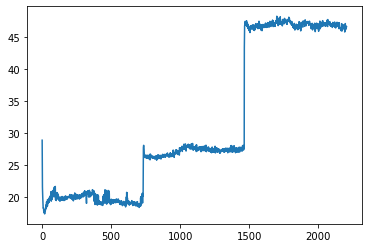

In [278]:
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

plt.plot(df["CE"], label="CE plot")

# Get first 400 lines to use in predicting and training
#data = pd.DataFrame(index=range(0, 400), columns=["Time", "CE"])
data = pd.DataFrame(index=range(0, len(df["CE"])), columns=["CE"])
for i in range(0, len(data)):
    #data["Time"][i] = df.index[i]
    data["CE"][i] = df["CE"][i]

#data["Time"] = data["Time"].astype(int)
data["CE"] = data["CE"].astype(float)

data.head()

In [279]:
scaler=MinMaxScaler(feature_range=(0,1))

dataset = scaler.fit_transform(data)

# split into train and test sets
# Train is the dataset which the model is trained on
# Test is the dataset which the model is verified with
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

1477 728


In [280]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [283]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [284]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 4s - loss: 0.0148
Epoch 2/50
 - 4s - loss: 0.0017
Epoch 3/50
 - 4s - loss: 4.4861e-04
Epoch 4/50
 - 3s - loss: 4.2633e-04
Epoch 5/50
 - 3s - loss: 4.0928e-04
Epoch 6/50
 - 3s - loss: 3.9281e-04
Epoch 7/50
 - 4s - loss: 3.9148e-04
Epoch 8/50
 - 3s - loss: 3.9204e-04
Epoch 9/50
 - 3s - loss: 3.9476e-04
Epoch 10/50
 - 3s - loss: 3.9609e-04
Epoch 11/50
 - 3s - loss: 3.9544e-04
Epoch 12/50
 - 3s - loss: 3.9058e-04
Epoch 13/50
 - 6s - loss: 3.9129e-04
Epoch 14/50
 - 3s - loss: 3.9227e-04
Epoch 15/50
 - 3s - loss: 3.9338e-04
Epoch 16/50
 - 3s - loss: 3.9208e-04
Epoch 17/50
 - 3s - loss: 3.9203e-04
Epoch 18/50
 - 4s - loss: 3.9192e-04
Epoch 19/50
 - 4s - loss: 3.9034e-04
Epoch 20/50
 - 5s - loss: 3.8636e-04
Epoch 21/50
 - 3s - loss: 3.9863e-04
Epoch 22/50
 - 4s - loss: 3.8748e-04
Epoch 23/50
 - 4s - loss: 3.8898e-04
Epoch 24/50
 - 4s - loss: 3.9316e-04
Epoch 25/50
 - 4s - loss: 3.8968e-04
Epoch 26/50
 - 3s - loss: 3.9189e-04
Epoch 27/50
 - 3s - loss: 3.9321e-04
Epoch 28/50
 - 3s 

In [287]:
# make predictions
import math
from sklearn.metrics import mean_squared_error 

## Random test shit, remove pls

#trainY = trainY["CE"]

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)

#reshape
trainY.reshape((len(trainY), 1))


trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)


testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.60 RMSE
Test Score: 0.32 RMSE


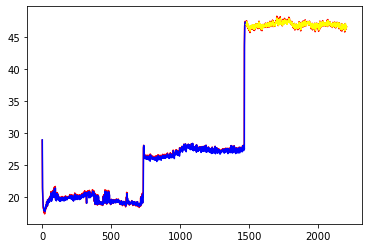

In [288]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color="red")
plt.plot(trainPredictPlot, color="blue")
plt.plot(testPredictPlot, color="yellow")
plt.show()

In [289]:
x = np.array([2805])

x = x.reshape((1, len(x), 1))

ypred = model.predict(x, verbose=0)

ypred

array([[1.8770286]], dtype=float32)

48.266


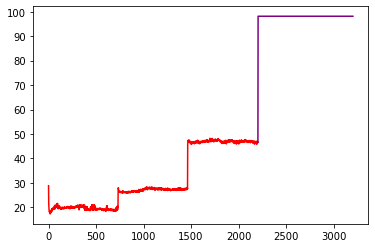

In [315]:
n_head = 1000
dataset_predict = scaler.inverse_transform(dataset)
dataset_predict = dataset_predict.reshape((-1))
print(max(dataset_predict))
#OriginalDataset = scaler.inverse_transform(dataset[-look_back:])
prediction_list = dataset_predict[-look_back:]
#print(prediction_list)
# Predict
for _ in range(n_head):
    x = prediction_list[-look_back:]
    x = x.reshape((1, look_back, 1))
    out = model.predict(x)[0][0]
    out = out * min(dataset_predict) + (max(dataset_predict)+min(dataset_predict))
    prediction_list = np.append(prediction_list, (out))
    
    
prediction_list = prediction_list[look_back-1:]
#print(prediction_list)

# Make new dataframe for predictions so we can plot them
# Make the index start after the baseline stops. So if baseline has index 0 to 1999,
# The first element in predictions_df should have an index of 2000.
prediction_df = pd.DataFrame(index=range(len(dataset) - 1, len(dataset) - 1 + len(prediction_list)), columns=["predictions"])
for i in range(len(prediction_list)):
    prediction_df["predictions"][len(dataset) - 1 + i] = prediction_list[i]

# plot baseline
dataset.reshape(1, -1)
plt.plot(scaler.inverse_transform(dataset), color="red")
# plt.plot(trainPredictPlot, color="blue")
# plt.plot(testPredictPlot, color="yellow")

# Plot the future predictions
plt.plot(prediction_df, color="purple")
plt.show()

In [317]:
dataset_predict = dataset_predict = scaler.inverse_transform(dataset)
prediction_list = dataset_predict[-lookback:]
# Predict
for  in range(n_head):
    x = prediction_list[-look_back:]
    x = x.reshape((1, look_back, 1))
    out = model.predict(x)[0][0]
    out = pd.DataFrame()
    dataset_predict = np.append(dataset_predict, out)
prediction_list = prediction_list[look_back-1:]
scaler.inverse_transform(dataset_predict)
print(prediction_list)
# Make new dataframe for predictions so we can plot them
# Make the index start after the baseline stops. So if baseline has index 0 to 1999,
# The first element in predictions_df should have an index of 2000.
prediction_df = pd.DataFrame(index=range(len(dataset) - 1, len(dataset) - 1 + len(prediction_list)), columns=["predictions"])
for i in range(len(prediction_list)):
    prediction_df["predictions"][len(dataset) - 1 + i] = prediction_list[i]

# plot baseline
dataset.reshape(1, -1)
plt.plot(scaler.inverse_transform(dataset), color="red")
# plt.plot(trainPredictPlot, color="blue")
# plt.plot(testPredictPlot, color="yellow")

# Plot the future predictions
plt.plot(prediction_df, color="purple")
plt.show()aa

SyntaxError: invalid syntax (Temp/ipykernel_19628/1058534249.py, line 4)